Chosen ETFS:

1. U.S. Market = SPDR S&P 500 ETF Trust (SPY)
2. International Market (ex-U.S.) = Vanguard Total International Stock ETF (VXUS)
3. U.S. Bonds = iShares Core US Aggregate Bond ETF (AGG)
4. International Bonds (ex-U.S.) = Bloomberg Global Treasury ex-US Capped Index (BWX)
5. Other Asset Class - SPDR Gold Shares (GLD)

Questions:
1. Something might be wrong with the annualized returns, they don't seem to match what I found online
2. Do we find the optimal weights and then run it through the create_portfolio() function or do we have to iterate through create_portfolio()
3. I think for the simulation part if we don't need create_portfolio() we can do something like this: https://www.mlq.ai/python-for-finance-portfolio-optimization/ with the part about the Monte Carlo simulations
4. Do we change the titles on the graphs from the ticker to the actual strategy (i.e. SPY -> U.S. Market)?

In [12]:
#Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta
import numpy as np

In [13]:
#Read in data about the 5 ETFs from WRDS
etfs = pd.read_csv('ETF Data.csv')
#Convert the date column to be a datetime data type
etfs['date'] = pd.to_datetime(etfs['date'], format="%m/%d/%Y")
#We noticed that BWX must've split on 9/28/2016, so we doubled all prices as an adjustment since the adjustment factor wasn't capturing this split
etfs.loc[(etfs['date']>=dt.strptime('9/29/2016', '%m/%d/%Y'))&(etfs['date']<=dt.strptime('12/31/2021', '%m/%d/%Y'))&(etfs['TICKER']=='BWX'),'PRC'] = etfs.loc[(etfs['date']>=dt.strptime('9/29/2016', '%m/%d/%Y'))&(etfs['date']<=dt.strptime('12/31/2021', '%m/%d/%Y'))&(etfs['TICKER']=='BWX'),'PRC']*2
#Find the daily return of each ETF
etfs['return'] = etfs.groupby(['TICKER'])['PRC'].pct_change()
#Make sure the dates are only on or after 12/31/2011 and on or before 12/31/2021
etfs = etfs[etfs['date']>=dt.strptime('12/31/2011', '%m/%d/%Y')]
etfs = etfs[etfs['date']<=dt.strptime('12/31/2021', '%m/%d/%Y')]

In [14]:
#set up empty data frame with 5 columns
etf_df = pd.DataFrame(columns=['Ticker', 'Annualized Return', 'Annualized Std', 'Sharpe Ratio', 'Max Drawdown'])
#Iterate through each of the 5 ETFs
for ticker in etfs['TICKER'].unique():
    #Look at only one ETF at a time
    subset_df = etfs[etfs['TICKER'] == ticker]
    #Compute cumulative return over the 10 years, then annualize
    cumulative_return = subset_df['PRC'].iloc[-1]/subset_df['PRC'].iloc[0]-1
    annualized_return = (1+cumulative_return)**(252/len(subset_df))-1
    #Get annualized standard deviation
    annualized_sd = subset_df['return'].std()*252**0.5
    #Find the Sharpe Ratio from the annualized return and standard deviation
    sharpe_ratio = annualized_return/annualized_sd
    #Get the max drawdown by subtracting the maximum price from the minimum price and dividing by the maximum price
    max_drawdown = (subset_df['PRC'].min()-subset_df['PRC'].max())/(subset_df['PRC'].max())
    #Add results to dataframe
    etf_df = etf_df.append({'Ticker': ticker, 'Annualized Return': annualized_return, 'Annualized Std': annualized_sd, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown}, ignore_index=True)

In [15]:
etf_df

,Ticker,Annualized Return,Annualized Std,Sharpe Ratio,Max Drawdown
0,VXUS,0.042144,0.168969,0.249417,-0.455556
1,SPY,0.140734,0.161904,0.869243,-0.732984
2,AGG,0.003626,0.040566,0.089375,-0.130569
3,GLD,0.009262,0.150798,0.061422,-0.481665
4,BWX,-0.004962,0.072477,-0.068461,-0.191892


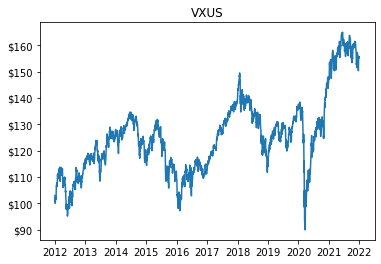

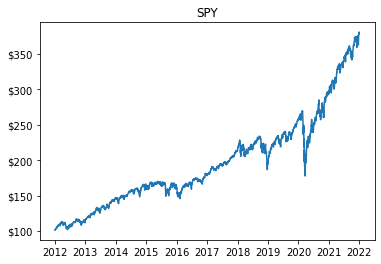

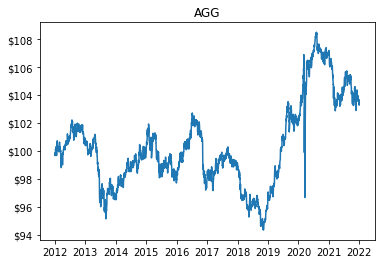

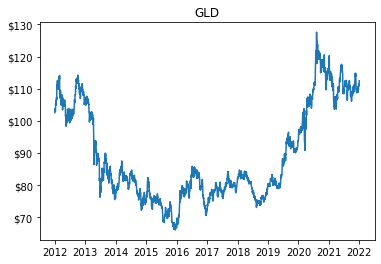

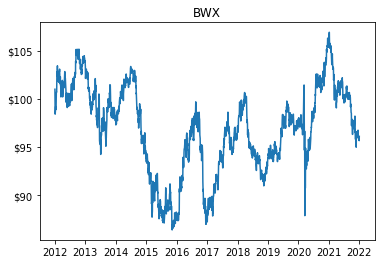

In [16]:
#Iterate through each ETF again
for ticker in etfs['TICKER'].unique():
    cumulative_returns = []
    subset_df = etfs[etfs['TICKER'] == ticker]

    for day in range(len(subset_df)):
        #For each day, get cumulative return up until that point
        cumulative_ret = (1+subset_df['return'].iloc[:day+1]).prod()
        #Add these cumulative returns to a list and multiply by 100 since we're looking at $100 invested
        cumulative_returns.append(cumulative_ret*100)
    #Plot performance of $100 invested at 12/31/2011 over time
    plt.plot(subset_df['date'], cumulative_returns)
    plt.title(ticker)
    plt.gca().yaxis.set_major_formatter('${x:1.0f}')

    plt.show()

In [17]:
#Make a new column for what month it is
etfs['month'] = etfs['date'].dt.to_period('M')

In [36]:
def cumulative_plot(data):
    #Since each ETF has the same total value for each date, we can just take the mean to extract the total value for a given date
    total_values = data.groupby('date')['total_val'].mean()
    #We then compute the percentage change in total value to get the daily portfolio return
    daily_returns = total_values.pct_change()
    #Make index of daily returns a column called date
    daily_returns = daily_returns.reset_index()
    #Set index of daily returns to be number 
    daily_returns.index = range(len(daily_returns))
    cumulative_returns = []
    for day in range(len(daily_returns)):
        #For each day, get cumulative return up until that point
        cumulative_ret = (1+daily_returns['total_val'].iloc[:day+1]).prod()
        #Add these cumulative returns to a list and multiply by 100 since we're looking at $100 invested
        cumulative_returns.append(cumulative_ret*100)
    #Plot performance of $100 invested at 12/31/2011 over time
    plt.plot(daily_returns['date'], np.array(cumulative_returns))
    plt.title('Portfolio Performance')
    plt.gca().yaxis.set_major_formatter('${x:1.0f}')
    plt.show()

In [19]:
def portfolio_analysis(data):
    #set up empty data frame with 5 columns
    result_df = pd.DataFrame(columns=['Annualized Return', 'Annualized Std', 'Sharpe Ratio', 'Max Drawdown'])
    #Since each ETF has the same total value for each date, we can just take the mean to extract the total value for a given date
    total_values = data.groupby('date')['total_val'].mean()
    #We then compute the percentage change in total value to get the daily portfolio return
    daily_returns = total_values.pct_change()
    #Compute cumulative return over the 10 years, then annualize
    cumulative_return = data['total_val'].iloc[-1]/data['total_val'].iloc[0]-1
    annualized_return = (1+cumulative_return)**(252/len(data['date'].unique()))-1
    #Get annualized standard deviation
    annualized_sd = daily_returns.std()*252**0.5
    #Find the Sharpe Ratio from the annualized return and standard deviation
    sharpe_ratio = annualized_return/annualized_sd
    #Get the max drawdown by subtracting the maximum price from the minimum price and dividing by the maximum price
    max_drawdown = (data['total_val'].min()-data['total_val'].max())/(data['total_val'].max())
    #Add results to dataframe
    result_df = result_df.append({'Annualized Return': annualized_return, 'Annualized Std': annualized_sd, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown}, ignore_index=True)
    
    return result_df

In [20]:
def create_portfolio(data,tickers,target_weights,min_date,max_date,initial_investment):
    etfs = data
    etfs = etfs[etfs['date']>=dt.strptime(min_date, '%m/%d/%Y')]
    etfs = etfs[etfs['date']<=dt.strptime(max_date, '%m/%d/%Y')]
    etfs = etfs[etfs['TICKER'].isin(tickers)]
    
    #Find the earliest date in the data
    first_date = etfs['date'].min()

    #Find the last day of each month
    last_days = etfs.groupby('month')['date'].max()
    
    for i in range(len(tickers)):
            #For the very first day of the data, update quantity so that it times the price divided by the total portfolio value is equal to the target weight
            #For now, the portfolio value is the initial investment value
            etfs.loc[(etfs['date']==first_date) & (etfs['TICKER']==tickers[i]), 'quantity'] = target_weights[i]/etfs.loc[(etfs['date']==first_date) & (etfs['TICKER']==tickers[i]), 'PRC']*initial_investment

    #For all na values in the quantity column (i.e. not the very first day), set the quantity to be the same as the previous day so all quantities match the first day of the month
    etfs['quantity'] = etfs['quantity'].fillna(method='ffill')
    #For all na values in the weighted value column (i.e. not the first day of the month), set the weighted value to be the quantity times the price
    etfs['weighted_val'] = etfs['quantity']*etfs['PRC']
    #Set total value column equal to sum of weighted values on that day
    etfs['total_val'] = etfs.groupby('date')['weighted_val'].transform('sum')
    #Compute weight as the weighted value of the ETF divided by the total value on that day
    etfs['weight'] = etfs['weighted_val']/etfs['total_val']

    #For all days except first_date, set quantity to na
    etfs.loc[etfs['date']!=first_date, 'quantity'] = np.nan
    for date in last_days.values:
        for i in range(len(tickers)):
                etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'quantity'] = target_weights[i]/etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'PRC']*etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val']

    #Re-establish quantity, weighted value, total value, and weight columns 
    etfs['quantity'] = etfs['quantity'].fillna(method='ffill')
    etfs['weighted_val'] = etfs['quantity']*etfs['PRC']
    etfs['total_val'] = etfs.groupby('date')['weighted_val'].transform('sum')
    etfs['weight'] = etfs['weighted_val']/etfs['total_val']
    return [portfolio_analysis(etfs),cumulative_plot(etfs)]
    

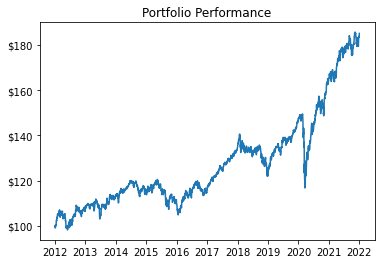

[   Annualized Return  Annualized Std  Sharpe Ratio  Max Drawdown
 0           0.063609        0.095564      0.665619     -0.470942,
 None]

In [37]:
target_weights = [0.3, 0.25, 0.2, 0.15, 0.1]
tickers = etfs['TICKER'].unique()
create_portfolio(etfs,tickers,target_weights,'1/3/2012','12/31/2021',100)

## This was what I tried earlier, just keeping it for now in case

In [11]:
# def create_portfolio(data,tickers,target_weights,min_date,max_date):
#     etfs = data
#     etfs = etfs[etfs['date']>=dt.strptime(min_date, '%m/%d/%Y')]
#     etfs = etfs[etfs['date']<=dt.strptime(max_date, '%m/%d/%Y')]
#     etfs = etfs[etfs['TICKER'].isin(tickers)]
    
#     #Find the first day of each month
#     first_days = etfs.groupby('month')['date'].min()
#     last_days = etfs.groupby('month')['date'].max()
#     #Set up dummy weights and quantities to get started
#     etfs['weight'] = 1/(len(etfs['TICKER'].unique()))

#     for date in first_days.values:
#         for i in range(len(tickers)):
#             #For the first day of each month, update quantity so that it times the price divided by the total portfolio value is equal to the target weight
#             #For now, assume that total portfolio value is $100 initially invested
#             etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'quantity'] = target_weights[i]/etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'PRC']*100

#     #For all na values in the quantity column (i.e. not the first day of the month), set the quantity to be the same as the previous day so all quantities match the first day of the month
#     etfs['quantity'] = etfs['quantity'].fillna(method='ffill')
#     #For all na values in the weighted value column (i.e. not the first day of the month), set the weighted value to be the quantity times the price
#     etfs['weighted_val'] = etfs['quantity']*etfs['PRC']
#     #Set total value column equal to sum of weighted values on that day
#     etfs['total_val'] = etfs.groupby('date')['weighted_val'].transform('sum')
#     #Compute weight as the weighted value of the ETF divided by the total value on that day
#     etfs['weight'] = etfs['weighted_val']/etfs['total_val']

#     for date in last_days.values:
#         for i in range(len(tickers)):
#             #Make a new column that is na for every day except the last day of the month where it has that day's total value
#             etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'last_total_val'] = etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val']
#     #Shift the column down one so that the first day of each month row has the total value of the last day of the previous month
#     etfs['last_total_val'] = etfs.groupby(['TICKER'])['last_total_val'].shift(1)

#     #Set all quantities to na so they can be reset
#     # etfs['quantity'] = np.nan
#     #etfs['last_total_val'] = np.nan
#     for date in etfs['date'].unique():
#         if date in first_days.values:
#             for i in range(len(tickers)):
#                 #Check if last total value is na so don't replace data for the very first day of each ticker
#                 if pd.notna(etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'last_total_val']).bool():
#                     #Change quantity so that it times the price equals the previous day's total value
#                     #set quantity for all rows in that month
#                     etfs.loc[(etfs['date']>=date) & (etfs['TICKER']==tickers[i]), 'quantity'] = target_weights[i]/etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'PRC']*etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'last_total_val']
#                     etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'weighted_val'] = etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'quantity']*etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'PRC']
#                     etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val'] = etfs.loc[(etfs['date']==date), 'weighted_val'].sum()
#                     etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'weight'] = etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'weighted_val']/etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val']
#                 else:
#                     #Set up the values the same way as above if last total value is na (i.e. for the very first day of each ticker)
#                     etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'quantity'] = target_weights[i]/etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'PRC']*etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val']
#                     etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'weighted_val'] = etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'quantity']*etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'PRC']
#                     etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val'] = etfs.loc[(etfs['date']==date), 'weighted_val'].sum()
#                     etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'weight'] = etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'weighted_val']/etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val']
#         else:
#             for j in range(len(tickers)):
#                 etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[j]), 'weighted_val'] = etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[j]), 'quantity']*etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[j]), 'PRC']
#                 etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[j]), 'total_val'] = etfs.loc[(etfs['date']==date), 'weighted_val'].sum()
#                 etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[j]), 'weight'] = etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[j]), 'weighted_val']/etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[j]), 'total_val']
#             if date in last_days.values:
#                 for i in range(len(tickers)):
#                     #Make a new column that is na for every day except the last day of the month where it has that day's total value
#                     etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'last_total_val'] = etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val']
#                 etfs['last_total_val'] = etfs.groupby(['TICKER'])['last_total_val'].shift(1)
#     #Re-establish quantity, weighted value, total value, and weight columns 
#     # etfs['quantity'] = etfs['quantity'].fillna(method='ffill')
#     # etfs['weighted_val'] = etfs['quantity']*etfs['PRC']
#     # etfs['total_val'] = etfs.groupby('date')['weighted_val'].transform('sum')
#     # etfs['weight'] = etfs['weighted_val']/etfs['total_val']
#     return etfs[150:200]

In [ ]:
# subset_df = etfs[etfs['date']>=first_days.)]
# price = np.array()
# # The number of shares for each security in the portfolio
# # at the beginning of each period
# quantity = np.zeros_like(price)

# initial_investment = 1
# target_weight = np.array([0.25, 0.25, 0.25, 0.25])

# for i in range(price.shape[0]):
#     if i == 0:
#         quantity[i] = initial_investment * target_weight / price[i]
#     else:
#         portfolio_value = (quantity[i-1] * price[i]).sum()
#         quantity[i] = portfolio_value * target_weight / price[i]